In [1]:
from dlroms import *
from dlroms.gp import GaussianRandomField
import numpy as np
from dolfin import *
from IPython.display import clear_output as clc
import os

### Darcy flow

The Darcy flow equation is solved using **mixed finite elements** with third-order Raviart-Thomas elements for the velocity, and fourth-order discontinuous elements for the pressure.

In [2]:
# Snapshots generation

# https://fenicsproject.org/qa/5518/solve-a-pde-with-an-integral-term/ (!)

# Injection term
class Injection(UserExpression):
    def __init__(self, w, r, **kwargs):
        self.w = w
        self.r = r
        super().__init__(**kwargs)

    def eval(self, values, x):
        if abs(x[0] - 0.5 * self.w) <= 0.5 * self.w and abs(x[1] - 0.5 * self.w) <= 0.5 * self.w:
            values[0] = self.r
        elif abs(x[0] + 0.5 * self.w - 1) <= 0.5 * self.w and abs(x[1] + 0.5 * self.w - 1) <= 0.5 * self.w:
            values[0] = - self.r
        else:
            values[0] = 0

    def value_shape(self):
        return ()

# Gaussian field
class Field(UserExpression):
    def __init__(self, field, **kwargs):
        self.field = field
        super().__init__(**kwargs)

    def eval(self, values, x):
        # values[0] = interpolate(x[0], x[1], mesh.coordinates(), self.field)
        V = fe.space(mesh, 'CG', 1)
        K = Function(V)
        K.vector()[:] = np.exp(self.field)
        values[0] = K(x)

    def value_shape(self):
        return ()

def Darcy(G, seed=0):
    """
    Solve the Darcy problem for a given instance of the input random field.
    Args:
        G, input random field
        seed, random seed
    """
    r = 10 # source rate
    w = 0.125 # source size

    # Function spaces
    # RT = FunctionSpace(mesh, "RT", 3)
    # DG = FunctionSpace(mesh, "DG", 4)
    # W  = MixedFunctionSpace([RT, DG]) # DEPRECATED
    RT_elem = FiniteElement("RT", mesh.ufl_cell(), 3)
    # DG_elem = FiniteElement("DG", mesh.ufl_cell(), 4)
    # CG_elem = FiniteElement("CG", mesh.ufl_cell(), 4)
    CG_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
    R_elem = FiniteElement("R", mesh.ufl_cell(), 0) # real number for Lagrange multiplier
    
    # W_elem = MixedElement([RT_elem, DG_elem, R_elem]) # dual formulation (velocity and pressure)
    # W_elem = MixedElement([DG_elem, R_elem]) # primal formulation (pressure)
    W_elem = MixedElement([CG_elem, R_elem]) # primal formulation (pressure)
    
    # W = FunctionSpace(mesh, W_elem) # mixed function space
    # W = FunctionSpace(mesh, DG_elem * R_elem) # mixed function space
    W = FunctionSpace(mesh, CG_elem * R_elem) # mixed function space

    # print('Function space dimension:', W.dim()) # 59161
    # print(W.sub(0).dim(), W.sub(1).dim(), W.sub(2).dim()) # 24480 34680 1

    # Trial and test functions
    # u, p, mu = TrialFunctions(W)
    # v, q, nu = TestFunctions(W)
    p, mu = TrialFunctions(W)
    q, nu = TestFunctions(W)

    f = Injection(w, r, degree=0) # f only takes constant values

    # Gaussian random field as an expression
    K = Field(G.sample(seed), degree=1)

    # Variational problem
    a = K * dot(grad(p), grad(q)) * dx + nu * p * dx + mu * q * dx
    L = f * q * dx

    # def boundary(x):
    #   return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS or x[1] > 1.0 - DOLFIN_EPS

    # bc = DirichletBC(W.sub(0), Constant((0, 0)), boundary)

    w = Function(W)
    # solve(a == L, w, bc)
    solve(a == L, w)
    # u, p, mu = w.split()
    p, mu = w.split(True)

    # Correct NaN values
    # u.vector().set_local(np.nan_to_num(u.vector().get_local()))
    # p.vector().set_local(np.nan_to_num(p.vector().get_local()))

    # Compute u from p
    V = FunctionSpace(mesh, RT_elem)
    # u = interpolate(- k * grad(p), V)
    u = Function(V)
    u.assign(project(- K * grad(p), V))

    # u = - K * grad(p)

    return u, p

In [4]:
domain = fe.rectangle((0.0, 0.0), (1.0, 1.0)) # - fe.rectangle((0.3, 0.3), (0.7, 0.7))
mesh = fe.mesh(domain, stepsize=0.05)
clc()

l = 0.1 # length scale

ker = lambda r: np.exp(- np.abs(r) / l)
KLE_dims = [10, 50, 500, 4255]

G = GaussianRandomField(mesh, kernel=ker, upto=50) # Euclidean version
# G_geo = GaussianRandomField(mesh, kernel=ker, upto=KLE_dims[0], domain=domain, geodesic_accuracy=0.03) # geodesic version (geodesic_accuracy?) # KeyError: 'stepsize'

u, p = Darcy(G)
clc()

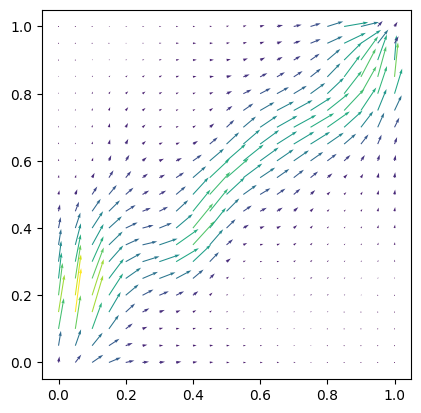

In [5]:
plot(u)

In [6]:
u_x = project(u[0], FunctionSpace(mesh, "CG", 1))
u_y = project(u[1], FunctionSpace(mesh, "CG", 1))

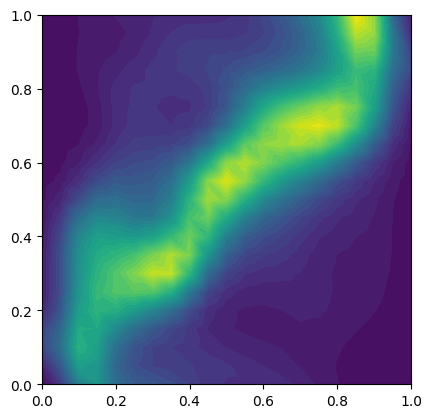

In [7]:
plot(u_x)

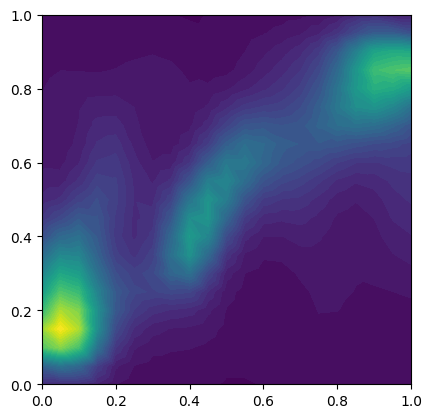

In [8]:
plot(u_y)

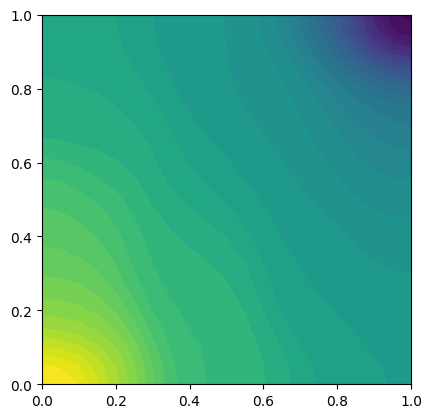

In [9]:
plot(p)

In [10]:
# Check integral constraint on p
print(assemble(p * dx(mesh)))

-5.800481622797449e-18


In [14]:
# Generate a toy dataset

n_samples = 10

domain = fe.rectangle((0.0, 0.0), (1.0, 1.0)) # - fe.rectangle((0.3, 0.3), (0.7, 0.7))
mesh = fe.mesh(domain, stepsize=0.05)
V = FunctionSpace(mesh, "CG", 1) # used both for p and for the components of u

l = 0.1 # length scale
ker = lambda r: np.exp(- np.abs(r) / l) # kernel
KLE_dims = [10, 50, 500, 4255]

G = GaussianRandomField(mesh, kernel=ker, upto=50) # Euclidean version
# G_geo = GaussianRandomField(mesh, kernel=ker, upto=KLE_dims[0], domain=domain, geodesic_accuracy=0.03) # geodesic version (geodesic_accuracy?) # KeyError: 'stepsize'

K_data = np.zeros((n_samples, G.sample(0).shape[0]))
p_data = np.zeros((n_samples, V.dim()))
u_x_data = np.zeros((n_samples, V.dim()))
u_y_data = np.zeros((n_samples, V.dim()))

snapshots_dir = './snapshots/'
if not os.path.exists(snapshots_dir):
    os.makedirs(snapshots_dir)

for n in range(n_samples):
	if n % 10 == 0:
		print(f'Generating snapshot {n+1} of {n_samples}...')
	u, p = Darcy(G, n)
	u_x = project(u[0], V)
	u_y = project(u[1], V)
	K_data[n] = np.exp(G.sample(n))
	p_data[n] = p.vector().get_local()
	u_x_data[n] = u_x.vector().get_local()
	u_y_data[n] = u_y.vector().get_local()

np.save(snapshots_dir+'K.npy', K_data)
np.save(snapshots_dir+'p.npy', p_data)
np.save(snapshots_dir+'u_x.npy', u_x_data)
np.save(snapshots_dir+'u_y.npy', u_y_data)

Generating snapshot 1 of 10...


In [16]:
# Reload data

K_reloaded = np.load(snapshots_dir+'K.npy')
p_reloaded = np.load(snapshots_dir+'p.npy')

print(K_reloaded.shape)
print(p_reloaded.shape)

(10, 441)
(10, 441)


In [21]:
# Print random snapshot

K = Function(V)
p = Function(V)

idx = 5
K.vector()[:] = K_reloaded[idx]
p.vector()[:] = p_reloaded[idx]

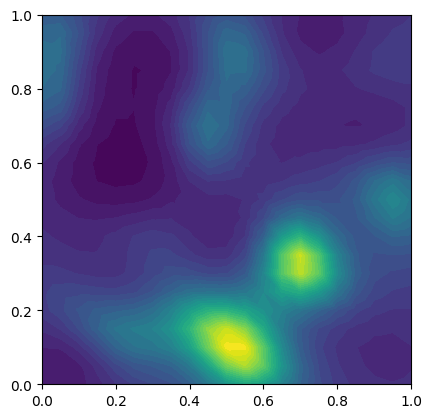

In [22]:
plot(K)

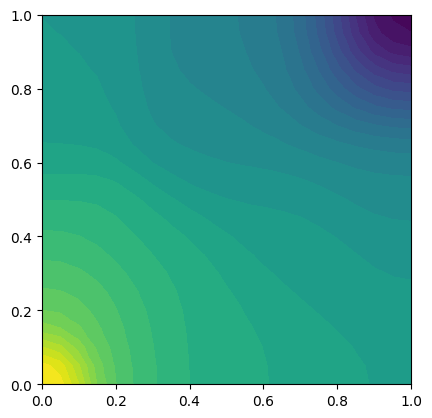

In [23]:
plot(p)